# Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones

<center>
<img 
     src="http://www2.famaf.unc.edu.ar/~efernandez/egeo/img/logos/famaf.jpg" 
     alt="Drawing" 
     style="width:30%;"
/>
</center>

### Universidad Nacional de Córdoba
---

In [7]:
import warnings
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import math

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from scipy import stats
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

from pandas.plotting import lag_plot

import pyarrow
import fastparquet

import statsmodels

In [2]:
df = pd.read_parquet('df_preprocesado.parquet')
df

,dni_titular_movimiento,anio_mes_cupon,antig_cliente,monto_ajustado,comercio_cat=0,comercio_cat=1,comercio_cat=2,comercio_cat=3,comercio_cat=4,comercio_cat=5,...,producto_naranja_movimiento=PL,producto_naranja_movimiento=PN,producto_naranja_movimiento=PP,producto_naranja_movimiento=TA,producto_naranja_movimiento=VI,producto_naranja_movimiento=ZE,tipo_producto_tarjeta_movimiento=0,tipo_producto_tarjeta_movimiento=3,tipo_producto_tarjeta_movimiento=4,fg_aumentado
0,000000b5aea2c9ea7cc155f6ebcef97f826,202008,225,-325.68,69.0,0.0,0.0,0.0,0.0,0.0,...,69.0,0.0,0.0,0.0,0.0,0.0,69.0,0.0,0.0,0
1,000000b5aea2c9ea7cc155f6ebcef97f826,202009,226,-318.09,69.0,0.0,0.0,0.0,0.0,0.0,...,69.0,0.0,0.0,0.0,0.0,0.0,69.0,0.0,0.0,0
2,000000b5aea2c9ea7cc155f6ebcef97f826,202010,227,-307.74,69.0,0.0,0.0,0.0,0.0,0.0,...,69.0,0.0,0.0,0.0,0.0,0.0,69.0,0.0,0.0,0
3,000000b5aea2c9ea7cc155f6ebcef97f826,202011,228,-299.46,69.0,0.0,0.0,0.0,0.0,0.0,...,69.0,0.0,0.0,0.0,0.0,0.0,69.0,0.0,0.0,0
4,000000b5aea2c9ea7cc155f6ebcef97f826,202012,229,-290.49,69.0,0.0,0.0,0.0,0.0,0.0,...,69.0,0.0,0.0,0.0,0.0,0.0,69.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7509,000f0b73ebfa002a79a0642b82e87919904,202101,21,801535.05,207.0,69.0,69.0,0.0,0.0,69.0,...,345.0,0.0,0.0,0.0,0.0,69.0,138.0,276.0,0.0,1
7510,000f0b73ebfa002a79a0642b82e87919904,202102,22,867100.92,207.0,69.0,0.0,0.0,0.0,0.0,...,207.0,0.0,0.0,0.0,0.0,69.0,138.0,138.0,0.0,0
7511,000f0b73ebfa002a79a0642b82e87919904,202103,23,183752.52,138.0,207.0,0.0,0.0,0.0,0.0,...,345.0,0.0,0.0,0.0,0.0,0.0,138.0,207.0,0.0,0
7512,000f0b73ebfa002a79a0642b82e87919904,202104,24,323309.16,276.0,0.0,138.0,0.0,0.0,0.0,...,345.0,0.0,0.0,0.0,0.0,69.0,138.0,276.0,0.0,1


In [3]:
df['monto_ajustado'].describe().round(2)

count       7514.00
mean      807589.43
std      1025642.13
min      -977066.91
25%        65113.61
50%       427092.40
75%      1177538.20
max      9249133.98
Name: monto_ajustado, dtype: float64

Distribución de nuestro target respecto a nuestros features

In [4]:
df_sin_docu = df.copy()
df_sin_docu.drop(columns=['dni_titular_movimiento','monto_ajustado'], inplace=True)
df_sin_docu['monto_ajustado'] = df['monto_ajustado']

In [5]:
col_x = df_sin_docu.iloc[:,:-1].columns.values
col_x

array(['anio_mes_cupon', 'antig_cliente', 'comercio_cat=0',
       'comercio_cat=1', 'comercio_cat=2', 'comercio_cat=3',
       'comercio_cat=4', 'comercio_cat=5', 'comercio_cat=6',
       'comercio_cat=7', 'comercio_cat=8', 'comercio_cat=9',
       'producto_naranja_movimiento=AX', 'producto_naranja_movimiento=EX',
       'producto_naranja_movimiento=MC', 'producto_naranja_movimiento=PC',
       'producto_naranja_movimiento=PL', 'producto_naranja_movimiento=PN',
       'producto_naranja_movimiento=PP', 'producto_naranja_movimiento=TA',
       'producto_naranja_movimiento=VI', 'producto_naranja_movimiento=ZE',
       'tipo_producto_tarjeta_movimiento=0',
       'tipo_producto_tarjeta_movimiento=3',
       'tipo_producto_tarjeta_movimiento=4', 'fg_aumentado'], dtype=object)

### ScatterPlot de Features y Target

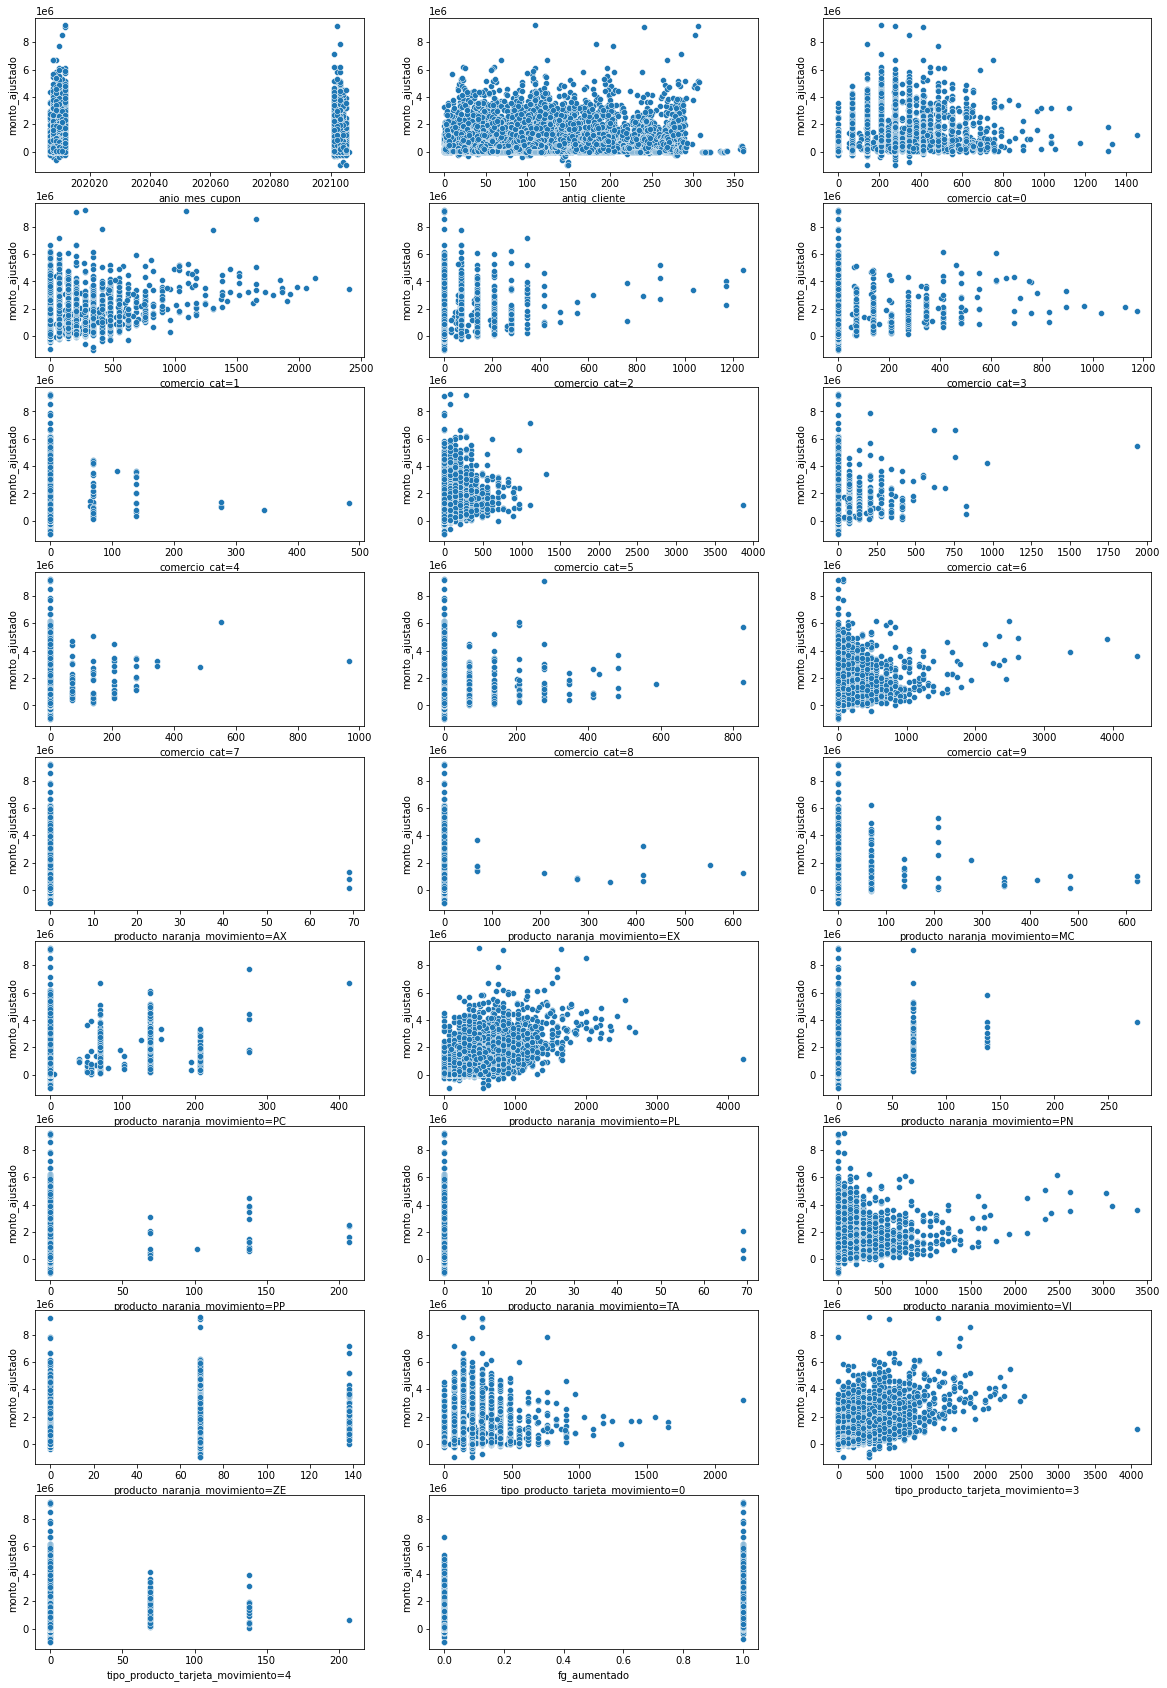

In [10]:
n_cols = 3
n_rows = math.ceil(len(col_x)/3)
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 30))
count = 0
for i in col_x:    
    # Calculamos filas y columnas
    row = math.floor(count / n_cols)
    col = count % n_cols
    # Configuramos visualización
    ax = axs[row, col]
    # Visualizamos la distribución de variable
    sns.scatterplot(data=df_sin_docu, x=i, y='monto_ajustado', ax=ax)
    count =count +1

axs[n_rows-1,n_cols-1].axis('off')
plt.show()

### División

En primer lugar, separamos nuestros feautures de los variables target para regresión y clasificación. La división entre train y validation se realizará previo a instanciar cada modelo, debido a que cada uno de ellos requiere un escalado distinto (por ejemplo, un escalado del tipo MaxAbsScaler, utiliza el máximo de todos los features para realizar el preprocesamiento). 

In [5]:
X = df.drop(['dni_titular_movimiento'], axis=1)

X_r = X.drop(['monto_ajustado'], axis=1)
X_c = X.drop(['fg_aumentado', 'monto_ajustado'], axis=1)
y_r = X['monto_ajustado']
y_c = X['fg_aumentado']

X_train_r, X_val_r, y_train_r, y_val_r = train_test_split(X_r, y_r, test_size=0.3, random_state=0, shuffle=False)
X_train_c, X_val_c, y_train_c, y_val_c = train_test_split(X_c, y_c, test_size=0.3, random_state=0, shuffle=False)

X_train_r = X_train_r.values
X_val_r = X_val_r.values
y_train_r = y_train_r.values.reshape(-1,1)
y_val_r = y_val_r.values.reshape(-1,1)

X_train_c = X_train_c.values
X_val_c = X_val_c.values
y_train_c = y_train_c.values
y_val_c = y_val_c.values

## 3. Regresión

Una vez finalizada la etapa de preprocesamiento, se propone implementar diferentes modelos 
de predicción para el `monto_compra_movimiento`, utilizando la librería Scikit-Learn:

* LinearSVR ([Doc](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVR.html#sklearn.svm.LinearSVR))
* SGDRegressor ([Doc](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html#sklearn.linear_model.SGDRegressor))
* KNeighborsRegressor ([Doc](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html#sklearn.neighbors.KNeighborsRegressor))
* GaussianProcessRegressor ([Doc](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html#sklearn.gaussian_process.GaussianProcessRegressor))
* VotingRegressor ([Doc](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingRegressor.html#sklearn.ensemble.VotingRegressor))

Y de la libreria XGBoost
* XGBRegressor ([Doc](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRegressor))

De estos tipos de modelos, cuál creen que es el más adecuado para nuestro caso de aplicación?

Utilizar el método Grid Search, o de búsqueda exahustiva, con cross-validation para profundizar en la búsqueda y selección de hiperparámetros.

Calcular métricas sobre el conjunto de entrenamiento y de evaluación para los mejores parámetros obtenidos:
* MSE 
* MAE 
* RMSE

Comparar las métricas obtenidas en cada modelo y obtener conclusiones.

> Una vez encontrado el mejor modelo se validara usando el conjunto de evaluacion dado por el mentor

### Linear SVR - Default

In [6]:
from sklearn.svm import LinearSVR

In [7]:
# división train y test
X_train_r, X_val_r, y_train_r, y_val_r = train_test_split(X_r, y_r, test_size=0.3, random_state=0, shuffle=False)

In [8]:
# escalado de feauteres y target
x_scaler = MinMaxScaler() #MaxAbsScaler()
y_scaler = MinMaxScaler() #MaxAbsScaler()
X_train_r = x_scaler.fit_transform(X_train_r)
X_val_r = x_scaler.fit_transform(X_val_r)
y_train_r = y_scaler.fit_transform(y_train_r.values.reshape(-1, 1))
y_val_r = y_scaler.fit_transform(y_val_r.values.reshape(-1, 1))

In [9]:
#standar= StandardScaler()
#standar.fit_transform(X_r[['anio_mes_cupon']].values.reshape(-1, 1))

In [10]:
X_r.head(10)

,anio_mes_cupon,antig_cliente,comercio_cat=0,comercio_cat=1,comercio_cat=2,comercio_cat=3,comercio_cat=4,comercio_cat=5,comercio_cat=6,comercio_cat=7,...,producto_naranja_movimiento=PL,producto_naranja_movimiento=PN,producto_naranja_movimiento=PP,producto_naranja_movimiento=TA,producto_naranja_movimiento=VI,producto_naranja_movimiento=ZE,tipo_producto_tarjeta_movimiento=0,tipo_producto_tarjeta_movimiento=3,tipo_producto_tarjeta_movimiento=4,fg_aumentado
0,202008,225,69.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,69.0,0.0,0.0,0.0,0.0,0.0,69.0,0.0,0.0,0
1,202009,226,69.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,69.0,0.0,0.0,0.0,0.0,0.0,69.0,0.0,0.0,0
2,202010,227,69.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,69.0,0.0,0.0,0.0,0.0,0.0,69.0,0.0,0.0,0
3,202011,228,69.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,69.0,0.0,0.0,0.0,0.0,0.0,69.0,0.0,0.0,0
4,202012,229,69.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,69.0,0.0,0.0,0.0,0.0,0.0,69.0,0.0,0.0,0
5,202101,230,69.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,69.0,0.0,0.0,0.0,0.0,0.0,69.0,0.0,0.0,0
6,202102,231,69.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,69.0,0.0,0.0,0.0,0.0,0.0,69.0,0.0,0.0,0
7,202103,232,69.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,69.0,0.0,0.0,0.0,0.0,0.0,69.0,0.0,0.0,0
8,202104,233,69.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,69.0,0.0,0.0,0.0,0.0,0.0,69.0,0.0,0.0,0
9,202105,234,69.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,69.0,0.0,0.0,0.0,0.0,0.0,69.0,0.0,0.0,0


In [11]:
pd.DataFrame(X_train_r, columns=X_r.columns.values).head(10)

,anio_mes_cupon,antig_cliente,comercio_cat=0,comercio_cat=1,comercio_cat=2,comercio_cat=3,comercio_cat=4,comercio_cat=5,comercio_cat=6,comercio_cat=7,...,producto_naranja_movimiento=PL,producto_naranja_movimiento=PN,producto_naranja_movimiento=PP,producto_naranja_movimiento=TA,producto_naranja_movimiento=VI,producto_naranja_movimiento=ZE,tipo_producto_tarjeta_movimiento=0,tipo_producto_tarjeta_movimiento=3,tipo_producto_tarjeta_movimiento=4,fg_aumentado
0,0.010101,0.625000,0.047619,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.016393,0.0,0.0,0.0,0.0,0.0,0.03125,0.0,0.0,0.0
1,0.020202,0.627778,0.047619,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.016393,0.0,0.0,0.0,0.0,0.0,0.03125,0.0,0.0,0.0
2,0.030303,0.630556,0.047619,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.016393,0.0,0.0,0.0,0.0,0.0,0.03125,0.0,0.0,0.0
3,0.040404,0.633333,0.047619,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.016393,0.0,0.0,0.0,0.0,0.0,0.03125,0.0,0.0,0.0
4,0.050505,0.636111,0.047619,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.016393,0.0,0.0,0.0,0.0,0.0,0.03125,0.0,0.0,0.0
5,0.949495,0.638889,0.047619,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.016393,0.0,0.0,0.0,0.0,0.0,0.03125,0.0,0.0,0.0
6,0.959596,0.641667,0.047619,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.016393,0.0,0.0,0.0,0.0,0.0,0.03125,0.0,0.0,0.0
7,0.969697,0.644444,0.047619,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.016393,0.0,0.0,0.0,0.0,0.0,0.03125,0.0,0.0,0.0
8,0.979798,0.647222,0.047619,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.016393,0.0,0.0,0.0,0.0,0.0,0.03125,0.0,0.0,0.0
9,0.989899,0.650000,0.047619,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.016393,0.0,0.0,0.0,0.0,0.0,0.03125,0.0,0.0,0.0


In [12]:
# fit
svr = LinearSVR(random_state=0)
svr.fit(X_train_r, y_train_r)

c:\python39\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
c:\python39\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


LinearSVR(random_state=0)

In [13]:
# Predict
y_train_pred_svr = svr.predict(X_train_r)
y_valid_pred_svr = svr.predict(X_val_r)

In [14]:
# evaluate MSE:
train_error_svr = mean_squared_error(y_train_r, y_train_pred_svr)
val_error_svr = mean_squared_error(y_val_r, y_valid_pred_svr)
print(f'Train error MSE {train_error_svr.round(3)}, Valid error MSE {val_error_svr.round(3)}') 

Train error MSE 0.006, Valid error MSE 0.008


In [15]:
# evaluate MAE:
train_error_svr = mean_absolute_error(y_train_r, y_train_pred_svr)
val_error_svr = mean_absolute_error(y_val_r, y_valid_pred_svr)
print(f'Train error MAE {train_error_svr.round(3)}, Valid error MAE {val_error_svr.round(3)}') 

Train error MAE 0.042, Valid error MAE 0.063


In [16]:
# evaluate RMSE:
train_error_svr = np.sqrt(mean_squared_error(y_train_r, y_train_pred_svr))
val_error_svr = np.sqrt(mean_squared_error(y_val_r, y_valid_pred_svr))
print(f'Train error RMSE {train_error_svr.round(3)}, Valid error RMSE {val_error_svr.round(3)}') 

Train error RMSE 0.074, Valid error RMSE 0.091


Visualizamos nuestra variable target (real y predicción)

In [17]:
pd.DataFrame(y_scaler.inverse_transform(y_val_r), columns=['val_real']).describe().round(2)

,val_real
count,2255.00
mean,797354.70
std,1058933.73
min,-977066.91
25%,59937.88
50%,397312.35
75%,1149325.76
max,9249133.98


In [18]:
pd.DataFrame(y_scaler.inverse_transform(y_valid_pred_svr.reshape(-1,1)), columns=['val_pred']).describe().round(2)

,val_pred
count,2255.00
mean,468173.72
std,1067813.27
min,-569085.90
25%,-316449.93
50%,148997.95
75%,886292.37
max,7175212.34


### Linear SVR - Grid Search

In [19]:
param_grid = {
    'epsilon': [0.1, 0.01, 0.0001,0.001],
    'tol': [1e-3, 1e-4, 1e-5, 1e-6],
    'C': [1, 2, 0.01, 0.001],
    'loss': ['epsilon_insensitive', 'squared_epsilon_insensitive']
}

cv_svr = GridSearchCV(svr, param_grid, scoring='neg_mean_squared_error',cv=5)
cv_svr.fit(X_train_r, y_train_r)

c:\python39\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
c:\python39\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
c:\python39\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
c:\python39\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
c:\python39\lib\site-packages\sklearn\svm\_base.py:985: Converg

GridSearchCV(cv=5, estimator=LinearSVR(random_state=0),
             param_grid={'C': [1, 2, 0.01, 0.001],
                         'epsilon': [0.1, 0.01, 0.0001, 0.001],
                         'loss': ['epsilon_insensitive',
                                  'squared_epsilon_insensitive'],
                         'tol': [0.001, 0.0001, 1e-05, 1e-06]},
             scoring='neg_mean_squared_error')

In [20]:
cv_svr.best_params_

{'C': 1, 'epsilon': 0.001, 'loss': 'squared_epsilon_insensitive', 'tol': 0.001}

In [21]:
cv_svr.best_estimator_

LinearSVR(C=1, epsilon=0.001, loss='squared_epsilon_insensitive',
          random_state=0, tol=0.001)

In [22]:
# Predict
y_train_pred_svr = cv_svr.best_estimator_.predict(X_train_r)
y_valid_pred_svr = cv_svr.best_estimator_.predict(X_val_r)

In [23]:
# evaluate MSE:
train_error_svr = mean_squared_error(y_train_r, y_train_pred_svr)
val_error_svr = mean_squared_error(y_val_r, y_valid_pred_svr)
print(f'Train error {train_error_svr.round(3)}, Valid error {val_error_svr.round(3)}')  

Train error 0.005, Valid error 0.007


In [24]:
# evaluate MAE:
train_error_svr = mean_absolute_error(y_train_r, y_train_pred_svr)
val_error_svr = mean_absolute_error(y_val_r, y_valid_pred_svr)
print(f'Train error MAE {train_error_svr.round(3)}, Valid error MAE {val_error_svr.round(3)}') 

Train error MAE 0.045, Valid error MAE 0.058


In [25]:
# evaluate RMSE:
train_error_svr = np.sqrt(mean_squared_error(y_train_r, y_train_pred_svr))
val_error_svr = np.sqrt(mean_squared_error(y_val_r, y_valid_pred_svr))
print(f'Train error RMSE {train_error_svr.round(3)}, Valid error RMSE {val_error_svr.round(3)}') 

Train error RMSE 0.071, Valid error RMSE 0.086


In [26]:
pd.DataFrame(y_scaler.inverse_transform(y_val_r), columns=['val_real']).describe().round(2)

,val_real
count,2255.00
mean,797354.70
std,1058933.73
min,-977066.91
25%,59937.88
50%,397312.35
75%,1149325.76
max,9249133.98


In [27]:
pd.DataFrame(y_scaler.inverse_transform(y_valid_pred_svr.reshape(-1,1)), columns=['val_pred']).describe().round(2)

,val_pred
count,2255.00
mean,603617.13
std,1072002.33
min,-534948.11
25%,-227026.46
50%,317971.55
75%,1065611.03
max,6938503.82


### SGDRegressor - Default

In [28]:
from sklearn.linear_model import SGDRegressor

Utilizamos las variables X_train_r, X_val_r, y_train_r, y_val_r debido a que en este modelo utilizamos el mismo escalado que SVM-R. 

In [29]:
# Fit
sgd = SGDRegressor(random_state=0, shuffle=False)
sgd.fit(X_train_r, y_train_r)

c:\python39\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


SGDRegressor(random_state=0, shuffle=False)

In [30]:
# Predict
y_train_pred_sgd = sgd.predict(X_train_r)
y_valid_pred_sgd = sgd.predict(X_val_r)

In [31]:
# evaluate:
train_error_sgd = mean_squared_error(y_train_r, y_train_pred_sgd)
val_error_sgd = mean_squared_error(y_val_r, y_valid_pred_sgd)
print(f'Train error {train_error_sgd.round(3)}, Valid error {val_error_sgd.round(3)}')  

Train error 0.007, Valid error 0.007


In [32]:
# evaluate MAE:
train_error_sgd = mean_absolute_error(y_train_r, y_train_pred_sgd)
val_error_sgd = mean_absolute_error(y_val_r, y_valid_pred_sgd)
print(f'Train error MAE {train_error_sgd.round(3)}, Valid error MAE {val_error_sgd.round(3)}') 

Train error MAE 0.054, Valid error MAE 0.055


In [33]:
# evaluate RMSE:
train_error_sgd = np.sqrt(mean_squared_error(y_train_r, y_train_pred_sgd))
val_error_sgd = np.sqrt(mean_squared_error(y_val_r, y_valid_pred_sgd))
print(f'Train error RMSE {train_error_sgd.round(3)}, Valid error RMSE {val_error_sgd.round(3)}') 

Train error RMSE 0.081, Valid error RMSE 0.086


Visualizamos nuestra variable target (real y predicción)

In [34]:
pd.DataFrame(y_scaler.inverse_transform(y_val_r), columns=['val_real']).describe().round(2)

,val_real
count,2255.00
mean,797354.70
std,1058933.73
min,-977066.91
25%,59937.88
50%,397312.35
75%,1149325.76
max,9249133.98


In [35]:
pd.DataFrame(y_scaler.inverse_transform(y_valid_pred_sgd.reshape(-1,1)), columns=['val_pred']).describe().round(2)

,val_pred
count,2255.00
mean,437006.97
std,657545.77
min,-450135.02
25%,-147802.88
50%,382783.38
75%,869062.60
max,3261997.15


### SGDRegressor- Grid Search

In [36]:
param_grid = {
    'loss': ['squared_loss','huber','epsilon_insensitive','squared_epsilon_insensitive'],
    'penalty': ['l2','l1'],
    'alpha': [0.001, 0.01, 0.1, 1],
    'epsilon': [0.1, 0.01],
    'tol': [1e-3, 1e-4],
    'learning_rate': ['optimal', 'constant', 'adaptive','invscaling']
    #'max_iter': [1000, 2000, 5000]
}

cv_sgd = GridSearchCV(sgd, param_grid, scoring='neg_mean_squared_error',cv=5)
cv_sgd.fit(X_train_r, y_train_r)

c:\python39\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
c:\python39\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1225: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
c:\python39\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
c:\python39\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1225: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of

GridSearchCV(cv=5, estimator=SGDRegressor(random_state=0, shuffle=False),
             param_grid={'alpha': [0.001, 0.01, 0.1, 1], 'epsilon': [0.1, 0.01],
                         'learning_rate': ['optimal', 'constant', 'adaptive',
                                           'invscaling'],
                         'loss': ['squared_loss', 'huber',
                                  'epsilon_insensitive',
                                  'squared_epsilon_insensitive'],
                         'penalty': ['l2', 'l1'], 'tol': [0.001, 0.0001]},
             scoring='neg_mean_squared_error')

In [37]:
cv_sgd.best_params_

{'alpha': 0.001,
 'epsilon': 0.01,
 'learning_rate': 'adaptive',
 'loss': 'squared_epsilon_insensitive',
 'penalty': 'l2',
 'tol': 0.0001}

In [38]:
cv_sgd.best_estimator_

SGDRegressor(alpha=0.001, epsilon=0.01, learning_rate='adaptive',
             loss='squared_epsilon_insensitive', random_state=0, shuffle=False,
             tol=0.0001)

In [39]:
# Predict
y_train_pred_sgd = cv_sgd.best_estimator_.predict(X_train_r)
y_valid_pred_sgd = cv_sgd.best_estimator_.predict(X_val_r)

In [40]:
# evaluate MSE:
train_error_sgd = mean_squared_error(y_train_r, y_train_pred_sgd)
val_error_sgd = mean_squared_error(y_val_r, y_valid_pred_sgd)
print(f'Train error {train_error_sgd.round(3)}, Valid error {val_error_sgd.round(3)}')  

Train error 0.005, Valid error 0.006


In [41]:
# evaluate MAE:
train_error_sgd = mean_absolute_error(y_train_r, y_train_pred_sgd)
val_error_sgd = mean_absolute_error(y_val_r, y_valid_pred_sgd)
print(f'Train error MAE {train_error_sgd.round(3)}, Valid error MAE {val_error_sgd.round(3)}') 

Train error MAE 0.047, Valid error MAE 0.054


In [42]:
# evaluate RMSE:
train_error_sgd = np.sqrt(mean_squared_error(y_train_r, y_train_pred_sgd))
val_error_sgd = np.sqrt(mean_squared_error(y_val_r, y_valid_pred_sgd))
print(f'Train error RMSE {train_error_sgd.round(3)}, Valid error RMSE {val_error_sgd.round(3)}') 

Train error RMSE 0.073, Valid error RMSE 0.081


Visualizamos nuestra variable target (real y predicción)

In [43]:
pd.DataFrame(y_scaler.inverse_transform(y_val_r), columns=['val_real']).describe().round(2)

,val_real
count,2255.00
mean,797354.70
std,1058933.73
min,-977066.91
25%,59937.88
50%,397312.35
75%,1149325.76
max,9249133.98


In [44]:
pd.DataFrame(y_scaler.inverse_transform(y_valid_pred_sgd.reshape(-1,1)), columns=['val_pred']).describe().round(2)

,val_pred
count,2255.00
mean,616436.90
std,988043.28
min,-469765.07
25%,-170363.43
50%,387642.70
75%,1084565.40
max,6765404.64


### KNeighborsRegressor - Default

In [45]:
from sklearn.neighbors import KNeighborsRegressor

In [46]:
neigh = KNeighborsRegressor(n_neighbors=5)
neigh.fit(X_train_r, y_train_r)

KNeighborsRegressor()

In [47]:
# Predict
y_train_pred_neigh = neigh.predict(X_train_r)
y_valid_pred_neigh = neigh.predict(X_val_r)

In [48]:
# evaluate:
train_error_neigh = mean_squared_error(y_train_r, y_train_pred_neigh)
val_error_neigh = mean_squared_error(y_val_r, y_valid_pred_neigh)
print(f'Train error {train_error_neigh.round(3)}, Valid error {val_error_neigh.round(3)}')

Train error 0.004, Valid error 0.009


In [49]:
pd.DataFrame(y_scaler.inverse_transform(y_val_r), columns=['val_real']).describe().round(2)

,val_real
count,2255.00
mean,797354.70
std,1058933.73
min,-977066.91
25%,59937.88
50%,397312.35
75%,1149325.76
max,9249133.98


In [50]:
pd.DataFrame(y_scaler.inverse_transform(y_valid_pred_neigh.reshape(-1,1)), columns=['val_pred']).describe().round(2)

,val_pred
count,2255.00
mean,370284.07
std,897088.31
min,-704705.50
25%,-371489.27
50%,135474.04
75%,860529.56
max,4861079.71


### KNeighborsRegressor - Grid Search

In [51]:
param_grid = {
    'n_neighbors': [2, 3, 4, 5],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto','ball_tree','kd_tree','brute'],
    'p': [1,2]
}

cv_neigh = GridSearchCV(neigh, param_grid, scoring='neg_mean_squared_error',cv=5)
cv_neigh.fit(X_train_r, y_train_r)

GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [2, 3, 4, 5], 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             scoring='neg_mean_squared_error')

In [52]:
cv_neigh.best_params_

{'algorithm': 'auto', 'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}

In [53]:
cv_neigh.best_estimator_

KNeighborsRegressor(p=1)

In [54]:
# Predict
y_train_pred_neigh = cv_neigh.best_estimator_.predict(X_train_r)
y_valid_pred_neigh = cv_neigh.best_estimator_.predict(X_val_r)

In [55]:
# evaluate MSE:
train_error_neigh = mean_squared_error(y_train_r, y_train_pred_neigh)
val_error_neigh = mean_squared_error(y_val_r, y_valid_pred_neigh)
print(f'Train error {train_error_neigh.round(3)}, Valid error {val_error_neigh.round(3)}')  

Train error 0.004, Valid error 0.009


In [56]:
# evaluate MAE:
train_error_neigh = mean_absolute_error(y_train_r, y_train_pred_neigh)
val_error_neigh = mean_absolute_error(y_val_r, y_valid_pred_neigh)
print(f'Train error MAE {train_error_neigh.round(3)}, Valid error MAE {val_error_neigh.round(3)}') 

Train error MAE 0.036, Valid error MAE 0.068


In [57]:
# evaluate RMSE:
train_error_neigh = np.sqrt(mean_squared_error(y_train_r, y_train_pred_neigh))
val_error_neigh = np.sqrt(mean_squared_error(y_val_r, y_valid_pred_neigh))
print(f'Train error RMSE {train_error_neigh.round(3)}, Valid error RMSE {val_error_neigh.round(3)}') 

Train error RMSE 0.062, Valid error RMSE 0.097


Visualizamos nuestra variable target (real y predicción)

In [58]:
pd.DataFrame(y_scaler.inverse_transform(y_val_r), columns=['val_real']).describe().round(2)

,val_real
count,2255.00
mean,797354.70
std,1058933.73
min,-977066.91
25%,59937.88
50%,397312.35
75%,1149325.76
max,9249133.98


In [59]:
pd.DataFrame(y_scaler.inverse_transform(y_valid_pred_neigh.reshape(-1,1)), columns=['val_pred']).describe().round(2)

,val_pred
count,2255.00
mean,314971.79
std,846623.30
min,-658108.61
25%,-383948.22
50%,82901.92
75%,768442.58
max,4260471.30


### GaussianProcessRegressor - Default

In [60]:
from sklearn.gaussian_process import GaussianProcessRegressor

In [61]:
# Toma por parametro un kernel por defecto que probablemente habria que optimizar 
gpr = GaussianProcessRegressor(random_state=0)
gpr.fit(X_train_r, y_train_r)

GaussianProcessRegressor(random_state=0)

In [62]:
# Predict
y_train_pred_gpr = gpr.predict(X_train_r)
y_valid_pred_gpr = gpr.predict(X_val_r)

In [63]:
# evaluate MSE:
train_error_gpr  = mean_squared_error(y_train_r, y_train_pred_gpr )
val_error_gpr  = mean_squared_error(y_val_r, y_valid_pred_gpr )
print(f'Train error {train_error_gpr .round(3)}, Valid error {val_error_gpr .round(3)}')  

Train error 0.0, Valid error 256.689


In [64]:
# evaluate MAE:
train_error_gpr = mean_absolute_error(y_train_r, y_train_pred_gpr)
val_error_gpr = mean_absolute_error(y_val_r, y_valid_pred_gpr)
print(f'Train error MAE {train_error_gpr.round(3)}, Valid error MAE {val_error_gpr.round(3)}') 

Train error MAE 0.007, Valid error MAE 4.268


In [65]:
# evaluate RMSE:
train_error_gpr = np.sqrt(mean_squared_error(y_train_r, y_train_pred_gpr))
val_error_gpr = np.sqrt(mean_squared_error(y_val_r, y_valid_pred_gpr))
print(f'Train error RMSE {train_error_gpr.round(3)}, Valid error RMSE {val_error_gpr.round(3)}') 

Train error RMSE 0.018, Valid error RMSE 16.022


In [66]:
pd.DataFrame(y_scaler.inverse_transform(y_val_r), columns=['val_real']).describe().round(2)

,val_real
count,2255.00
mean,797354.70
std,1058933.73
min,-977066.91
25%,59937.88
50%,397312.35
75%,1149325.76
max,9249133.98


In [67]:
pd.DataFrame(y_scaler.inverse_transform(y_valid_pred_gpr.reshape(-1,1)), columns=['val_pred']).describe().round(2)

,val_pred
count,2.255000e+03
mean,-5.135675e+06
std,1.636724e+08
min,-2.400261e+09
25%,-3.079007e+06
50%,-1.418864e+05
75%,5.234802e+06
max,2.705363e+09


### GaussianProcessRegressor - Grid Search (FALTAN VER PARAMETROS)

In [ ]:
param_grid = {
    'n_neighbors': [2, 3, 4, 5],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto','ball_tree','kd_tree','brute'],
    'p': [1,2]
    #'max_iter': [1000, 2000, 5000]
}

cv_gpr = GridSearchCV(neigh, param_gpr, scoring='neg_mean_squared_error',cv=5)
cv_gpr.fit(X_train_r, y_train_r)

In [ ]:
cv_gpr.best_params_

In [ ]:
cv_gpr.best_estimator_

In [ ]:
# Predict
y_train_pred_gpr = cv_gpr.best_estimator_.predict(X_train_r)
y_valid_pred_gpr = cv_gpr.best_estimator_.predict(X_val_r)

In [ ]:
# evaluate MSE:
train_error_gpr = mean_squared_error(y_train_r, y_train_pred_gpr)
val_error_gpr = mean_squared_error(y_val_r, y_valid_pred_gpr)
print(f'Train error {train_error_gpr.round(3)}, Valid error {val_error_gpr.round(3)}')  

In [ ]:
# evaluate MAE:
train_error_gpr = mean_absolute_error(y_train_r, y_train_pred_gpr)
val_error_gpr = mean_absolute_error(y_val_r, y_valid_pred_gpr)
print(f'Train error MAE {train_error_gpr.round(3)}, Valid error MAE {val_error_gpr.round(3)}') 

In [ ]:
# evaluate RMSE:
train_error_gpr = np.sqrt(mean_squared_error(y_train_r, y_train_pred_gpr))
val_error_gpr = np.sqrt(mean_squared_error(y_val_r, y_valid_pred_gpr))
print(f'Train error RMSE {train_error_gpr.round(3)}, Valid error RMSE {val_error_gpr.round(3)}') 

Visualizamos nuestra variable target (real y predicción)

In [ ]:
pd.DataFrame(y_scaler.inverse_transform(y_val_r), columns=['val_real']).describe().round(2)

In [ ]:
pd.DataFrame(y_scaler.inverse_transform(y_valid_pred_gpr.reshape(-1,1)), columns=['val_pred']).describe().round(2)

### VotingRegressor

In [ ]:
from sklearn.ensemble import VotingRegressor

In [26]:
vr = VotingRegressor([('svr', svr), ('sgd', sgd), ('neigh', neigh), ('gpr', gpr)])
vr.fit(X_train_r, y_train_r)

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


VotingRegressor(estimators=[('svr', LinearSVR(random_state=0, tol=1e-05)),
                            ('sgd', SGDRegressor(random_state=0)),
                            ('neigh', KNeighborsRegressor()),
                            ('gpr', GaussianProcessRegressor(random_state=0))])

In [27]:
# Predict
y_train_pred = vr.predict(X_train_r)
y_valid_pred = vr.predict(X_val_r)

In [28]:
# evaluate:
train_error = mean_squared_error(y_train_r, y_train_pred)
val_error = mean_squared_error(y_val_r, y_valid_pred)
print(f'Train error {train_error.round(3)}, Valid error {val_error.round(3)}')

Train error 1.1353003220831208e+34, Valid error 1.133429489736125e+34


## 4. Clasificación
Una vez finalizada la etapa de preprocesamiento, se propone implementar diferentes modelos 
de predicción para la variable que indica si el consumo sera mas alto, o menor en el mes siguiente, utilizando la librería Scikit-Learn:

* RandomForestClassifier ([Doc](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html))

Y de la libreria XGBoost
* XGBClassifier ([Doc](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBClassifier))

Comparar 
* precision
* recall  
* f1-score
* Accuracy

Comparar las métricas obtenidas en cada modelo y obtener conclusiones.

> Una vez encontrado el mejor modelo se validara usando el conjunto de evaluacion dado por el mentor

In [110]:
X_train_c.shape

(5259, 25)

In [111]:
y_train_c.shape

(5259, 1)

In [112]:
X_val_c.shape

(2255, 25)

In [113]:
y_val_c.shape

### RandomForestClassifier

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

In [51]:
# Fit

param_grid = {
    'max_depth': [10, 15, 20, 25],
    'criterion':['gini', 'entropy'],
    'min_samples_split': [5, 10, 15, 20, 25],
    'min_samples_leaf':[4, 5, 6, 8]}

dtc = RandomForestClassifier(random_state= 0)
clf = GridSearchCV(dtc, param_grid, scoring='f1', cv=5, verbose=1)
clf.fit(X_train_c, y_train_c)

Fitting 5 folds for each of 160 candidates, totalling 800 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 15, 20, 25],
                         'min_samples_leaf': [4, 5, 6, 8],
                         'min_samples_split': [5, 10, 15, 20, 25]},
             scoring='f1', verbose=1)

In [52]:
# Predict
y_train_pred = clf.predict(X_train_c)
y_val_pred = clf.predict(X_val_c)

In [53]:
# Evaluate train
text = "RandomForestClassifier - Reporte de clasificación del conjunto de train" 
print(len(text)*"=")
print(text)
print(len(text)*"=")
print(classification_report(y_train_c, y_train_pred))

RandomForestClassifier - Reporte de clasificación del conjunto de train
              precision    recall  f1-score   support

           0       0.80      0.93      0.86      3444
           1       0.81      0.56      0.66      1815

    accuracy                           0.80      5259
   macro avg       0.81      0.75      0.76      5259
weighted avg       0.80      0.80      0.79      5259



In [54]:
# Evaluate val
text = "RandomForestClassifier - Reporte de clasificación del conjunto de validacion" 
print(len(text)*"=")
print(text)
print(len(text)*"=")
print(classification_report(y_val_c, y_val_pred))

RandomForestClassifier - Reporte de clasificación del conjunto de validacion
              precision    recall  f1-score   support

           0       0.72      0.85      0.78      1443
           1       0.60      0.41      0.49       812

    accuracy                           0.69      2255
   macro avg       0.66      0.63      0.63      2255
weighted avg       0.68      0.69      0.67      2255



### XGBoost

In [59]:
from xgboost import XGBClassifier

In [64]:
param_grid = {
    'max_depth': [10],
    'n_estimators': [5],
    'booster':['gbtree', 'gblinear', 'dart'],
}

xgb = XGBClassifier(random_state= 0)
clf = GridSearchCV(xgb, param_grid, scoring='f1', cv=5)
clf.fit(X_train_c, y_train_c)

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:13:58] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:13:58] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Use

[21:13:58] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:13:58] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:13:58] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Use

[21:13:58] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:13:58] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:13:58] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { max_depth } might not be used.

  

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Use

[21:13:59] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:13:59] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:13:59] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=0,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, va

In [65]:
# Predict
y_train_pred = clf.predict(X_train_c)
y_val_pred = clf.predict(X_val_c)

In [66]:
# Evaluate train
text = "XGBClassifier - Reporte de clasificación del conjunto de train" 
print(len(text)*"=")
print(text)
print(len(text)*"=")
print(classification_report(y_train_c, y_train_pred))

XGBClassifier - Reporte de clasificación del conjunto de train
              precision    recall  f1-score   support

           0       0.82      0.93      0.87      3444
           1       0.83      0.61      0.71      1815

    accuracy                           0.82      5259
   macro avg       0.83      0.77      0.79      5259
weighted avg       0.82      0.82      0.82      5259



In [67]:
# Evaluate val
text = "XGBClassifier - Reporte de clasificación del conjunto de validacion" 
print(len(text)*"=")
print(text)
print(len(text)*"=")
print(classification_report(y_val_c, y_val_pred))

XGBClassifier - Reporte de clasificación del conjunto de validacion
              precision    recall  f1-score   support

           0       0.72      0.81      0.76      1443
           1       0.56      0.43      0.49       812

    accuracy                           0.67      2255
   macro avg       0.64      0.62      0.62      2255
weighted avg       0.66      0.67      0.66      2255



## 5. Series Temporales (Optativo)
* Hacer un forecasting usando Exponential Smoothing

En el modelo de Exponential Smoothing, las predicciones son promedios pesados de observaciones pasadas, donde los pesos decaen exponencialmente cuando nos movemos al pasado:
$$
\hat{y}_{t + 1} = l_t \\
l_t = \alpha y_t + (1 - \alpha) l_{t - 1}
$$

Donde:

Asumimos que:
* $l_0$ está dado
* 0 $< \alpha <$ 1

El método se suele usar cuando los datos no tienen patrones de tendencia ni estacional claros.


In [2]:
print(statsmodels.__version__)
warnings.filterwarnings('ignore')
%matplotlib inline

0.12.2


In [3]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(15, 10)})

Para cargar el dataset

In [4]:
df = pd.read_parquet("cupones_ds.parquet")

In [5]:
df.head(5)

,dni_titular_movimiento,moneda_movimiento,id_comercio_movimiento,nombre_comercio_histo,numero_cupon_movimiento,debito_credito_movimiento,producto_naranja_movimiento,codigo_empresa_movimiento,tipo_producto_tarjeta_movimiento,plan_movimiento,...,sexo_descripcion,pais,provincia,ciudad,domicilio_codigo_postal,domicilio_barrio,fecha_de_ingreso_histo,cargo_descripcion_histo,nivel_estudio_descripcion_histo,rel_vivienda_descripcion_histo
0,0001686b52949b5461ffcbc766687e45031,0,20099784,INTERES POR MORA U$S,200813,0,PL,1,0,1,...,Hombre,Argentina,BUENOS AIRES,LA TABLADA,1766.0,LA TABLADA,2012-12-11,EMP.DE COMERCIO,SECUNDARIOS,Propia
1,000220fa96ec5af89817894033f8099c547,0,20099784,INTERES POR MORA U$S,200813,0,PL,1,0,1,...,Mujer,Argentina,MENDOZA,VA.NVA. DE GUAYMALLEN,5521.0,GLLEN,2020-06-10,SIN DATOS,None,None
2,0002be202de47dfae9cc2304d91161be595,0,20099784,INTERES POR MORA U$S,200813,0,PL,1,0,1,...,Mujer,Argentina,BUENOS AIRES,SANTA TERESITA,7107.0,SANTA TERESITA,2012-09-13,SIN DATOS,PRIMARIOS,Otros
3,000e137d0af42e193be1ff670c00d4d1506,0,20099784,INTERES POR MORA U$S,200813,0,PL,1,0,1,...,Hombre,Argentina,SANTA FE,SAN LORENZO,2200.0,BOUCHARD,2008-01-15,EMP.DE COMERCIO,SECUNDARIOS,Propia
4,0009d010e4faf69552a814a33832b185877,0,20099784,INTERES POR MORA U$S,200813,0,PL,1,0,1,...,Mujer,Argentina,CAPITAL FEDERAL,CIUDAD AUTONOMA DE BUENOS AIRES,1019.0,SAN NICOLAS,2013-06-06,EMP.DE COMERCIO,UNIVERSITARIOS,Alquilada


In [6]:
cols = ['producto_naranja_movimiento', 'monto_compra_movimiento', 'fecha_cupon_movimiento']

In [7]:
df[cols]

,producto_naranja_movimiento,monto_compra_movimiento,fecha_cupon_movimiento
0,PL,6.24,2020-08-25
1,PL,17.73,2020-08-25
2,PL,6.18,2020-08-25
3,PL,2.83,2020-08-25
4,PL,2.38,2020-08-25
...,...,...,...
4092072,PL,2.29,2021-02-03
4092073,PL,229.90,2021-01-25
4092074,PL,4.64,2020-09-02
4092075,PL,12.22,2020-11-02


In [8]:
sf = df[cols][df.producto_naranja_movimiento == 'PL']
sf

,producto_naranja_movimiento,monto_compra_movimiento,fecha_cupon_movimiento
0,PL,6.24,2020-08-25
1,PL,17.73,2020-08-25
2,PL,6.18,2020-08-25
3,PL,2.83,2020-08-25
4,PL,2.38,2020-08-25
...,...,...,...
4092072,PL,2.29,2021-02-03
4092073,PL,229.90,2021-01-25
4092074,PL,4.64,2020-09-02
4092075,PL,12.22,2020-11-02


In [9]:
cols = ['fecha_cupon_movimiento', 'monto_compra_movimiento']
sf = sf[cols].groupby(by=['fecha_cupon_movimiento'], dropna=True).sum()

In [10]:
sf.reset_index(inplace=True)
sf

,fecha_cupon_movimiento,monto_compra_movimiento
0,2020-02-16,71760.00
1,2020-04-01,69055.20
2,2020-05-27,146558.07
3,2020-06-25,-22098.63
4,2020-07-01,-39054.00
...,...,...
289,2021-04-30,-235966.89
290,2021-05-02,-1653081.99
291,2021-05-06,3462.42
292,2021-05-10,90.39


In [11]:
print(sf['fecha_cupon_movimiento'].max())
print(sf['fecha_cupon_movimiento'].min())

2021-05-25
2020-02-16


In [12]:
sf.set_index('fecha_cupon_movimiento', inplace=True)
sf

,monto_compra_movimiento
fecha_cupon_movimiento,
2020-02-16,71760.00
2020-04-01,69055.20
2020-05-27,146558.07
2020-06-25,-22098.63
2020-07-01,-39054.00
...,...
2021-04-30,-235966.89
2021-05-02,-1653081.99
2021-05-06,3462.42


En series temporales se usa Series en lugar de Dataframe

In [13]:
ss = sf['monto_compra_movimiento']
ss

fecha_cupon_movimiento
2020-02-16      71760.00
2020-04-01      69055.20
2020-05-27     146558.07
2020-06-25     -22098.63
2020-07-01     -39054.00
                 ...    
2021-04-30    -235966.89
2021-05-02   -1653081.99
2021-05-06       3462.42
2021-05-10         90.39
2021-05-25     320269.71
Name: monto_compra_movimiento, Length: 294, dtype: float64

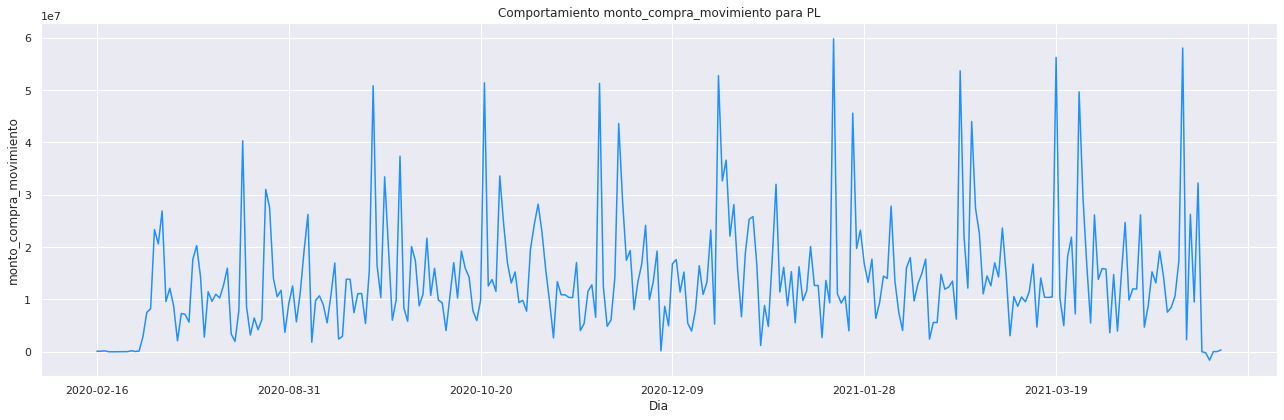

In [14]:
fig = plt.figure(figsize=(18, 6))

ax = plt.subplot(1, 1, 1)
ss.plot(color='dodgerblue')
ax.set_xlabel('Dia')
ax.set_ylabel('monto_compra_movimiento')
ax.set_title('Comportamiento monto_compra_movimiento para PL')

plt.tight_layout()
plt.show()

In [15]:
y_test = sf.monto_compra_movimiento.loc['2021-03-19':]
y_train = sf[~sf.monto_compra_movimiento.isin(y_test)].monto_compra_movimiento


In [16]:
print(y_test.index.max())
print(y_test.index.min())

2021-05-25
2021-03-19


In [17]:
print(y_train.index.max())
print(y_train.index.min())

2021-03-18
2020-02-16


## Seasonal Random Walk (Seasonal Naïve)

#### Descomposicion

Una operación fundamental para entender el comportamiento de una serie de
 tiempo y poder determinar si se trata de una serie `estacionaria` o no

La **descomposición** es una técnica que trata de descomponer una serie de tiempo en su tendencia, su estacionalidad y sus factores residuales

Ejemplo de descomposición de serie de tiempo

<img 
src="https://i.imgur.com/g0PQASf.png" />


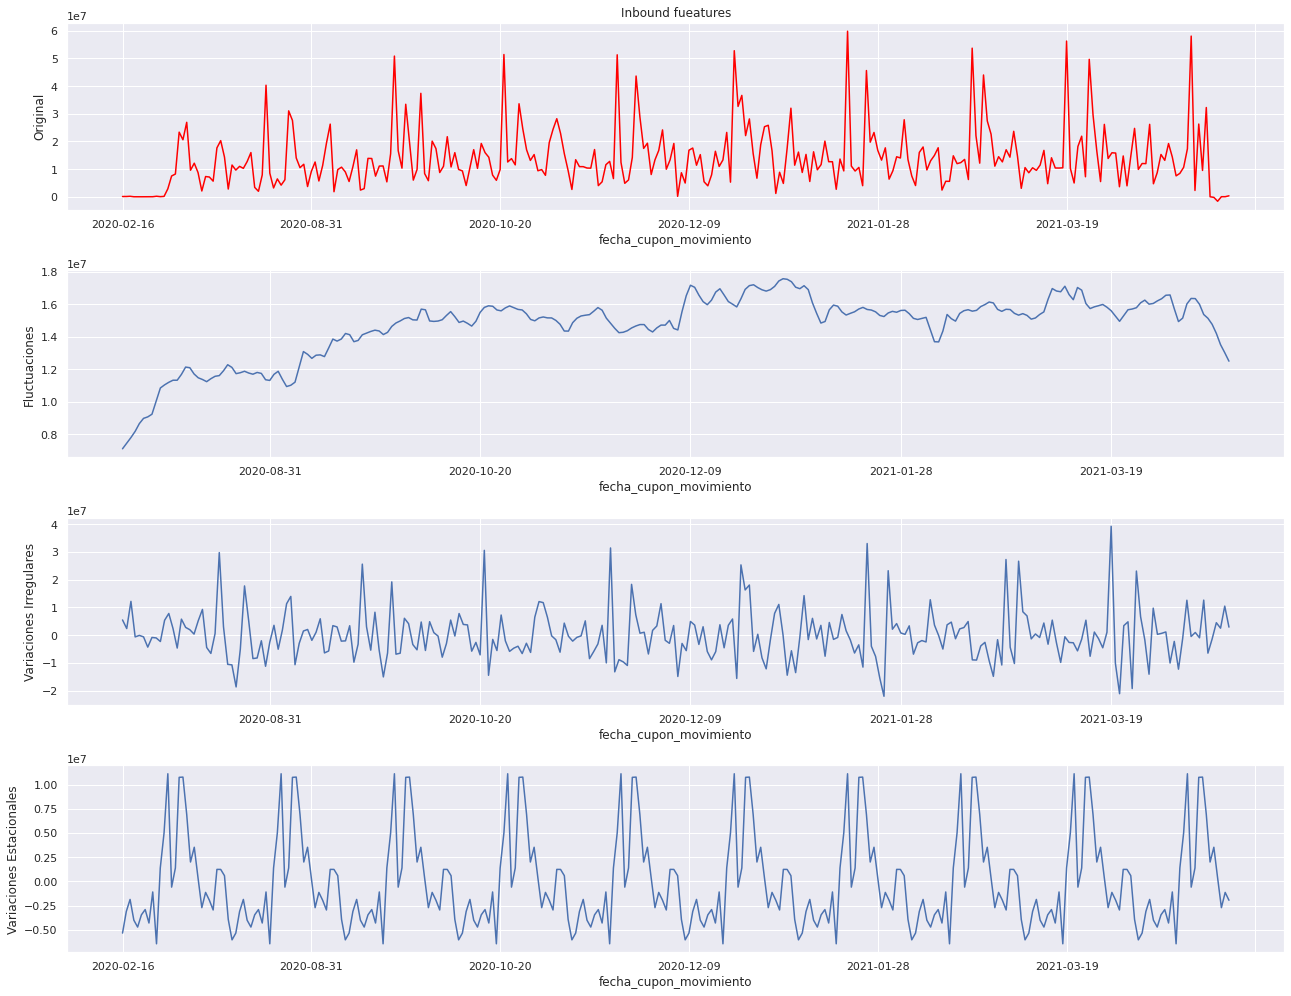

In [18]:
res = sm.tsa.seasonal_decompose(
    sf['monto_compra_movimiento'], model='additive', freq=30
    )

fig, (ax1,ax2,ax3, ax4) = plt.subplots(4,1, figsize=(18, 14))

ax1.set_title('Inbound fueatures')
sf.monto_compra_movimiento.plot(ax=ax1, color='red')
ax1.set_ylabel('Original')

res.trend.plot(ax=ax2)
ax2.set_ylabel('Fluctuaciones')

res.resid.plot(ax=ax3)
ax3.set_ylabel('Variaciones Irregulares')

res.seasonal.plot(ax=ax4)
ax4.set_ylabel('Variaciones Estacionales')
plt.tight_layout()
plt.show()

## Forecast

In [19]:
model = ARIMA(
    endog=y_train, exog=None, order=(0, 0, 1), seasonal_order=(0, 1, 0, 42)
    ).fit()
    

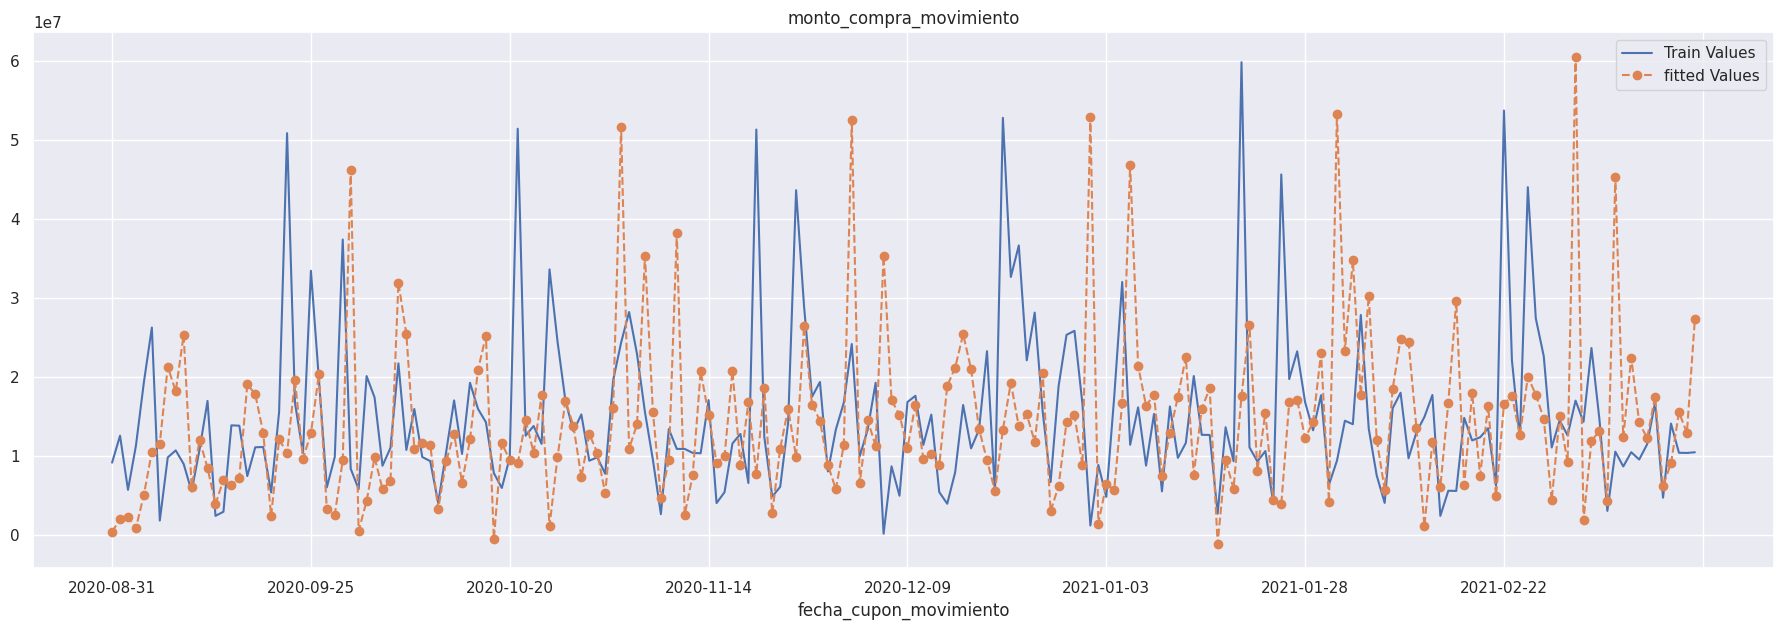

In [20]:
fig = plt.figure(figsize=(18, 12), dpi=100)

ax = plt.subplot(2, 1, 1)
y_train.tail(200).plot(ax=ax, label='Train Values', linestyle='-')
model.fittedvalues.tail(200).plot(
    ax=ax, label='fitted Values', marker='o', linestyle='--')
ax.set_title('monto_compra_movimiento')
ax.legend()

plt.tight_layout()
plt.show()

In [21]:
# Forecast
# 95% conf se, conf
fc = model.forecast(steps=len(y_test), exog=y_test, alpha=0.05) 
#Make as pandas series
fc_in = fc.reset_index(drop=True)
fc_in.index = y_test.index

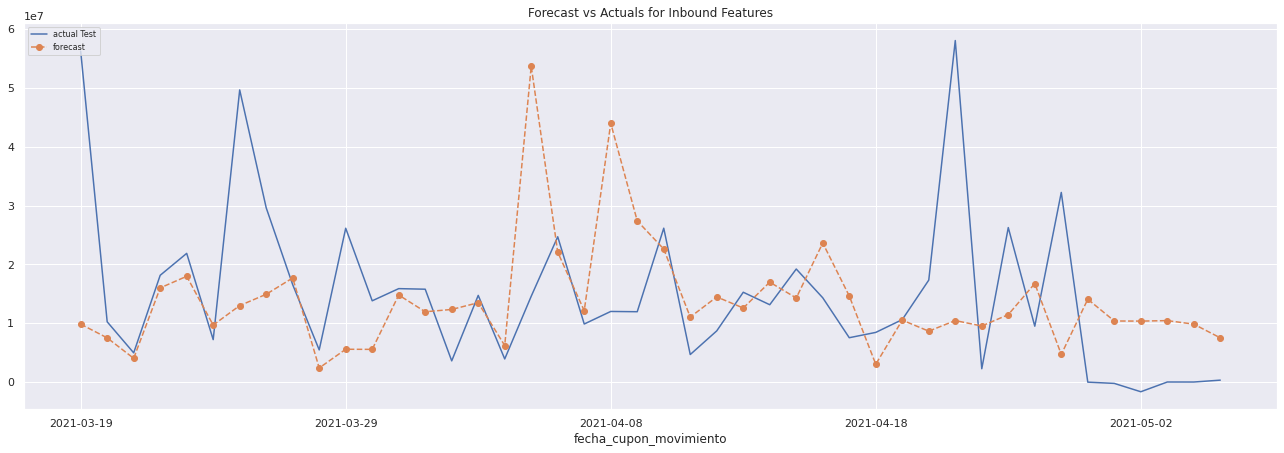

In [22]:
fig = plt.figure(figsize=(18, 12))

ax = plt.subplot(2, 1, 1)
y_test.plot(ax=ax, label='actual Test')
fc_in.plot(ax=ax, label='forecast', marker='o', linestyle='--')
ax.set_title('Forecast vs Actuals for Inbound Features')
ax.legend(loc='upper left', fontsize=8)

plt.tight_layout()
plt.show()

In [23]:
table = pd.DataFrame(
    [(sm.tools.eval_measures.rmse(y_test, fc_in), 
      (y_test - fc_in).sem())],
      columns=['RMSE','SE']
      )
table.round(3)

,RMSE,SE
0,1.623687e+07,2470284.646
